# **导入相关包**

In [1]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# **超参数设置**

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # 选择设备

learning_rate = 1e-4
epoches = 10
batch_size = 64

# **数据集处理**

In [3]:
test_dir = '../data/ImageNet Dogs/train_valid_test/test'
train_dir = '../data/ImageNet Dogs/train_valid_test/train'
valid_dir = '../data/ImageNet Dogs/train_valid_test/valid'

In [4]:
# 数据增强
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),  # 随机裁剪图像
    transforms.RandomHorizontalFlip(),   # 随机翻转
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # 随机改变亮度、对比度
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **ResNet34网络**

In [7]:
from torchvision.models import resnet34
# 修改预训练模型保存地址
os.environ['TORCH_HOME'] = '../torch_model'

class ResNet34(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()
        self.model = resnet34(weights='DEFAULT')
        self.in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(self.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

model = ResNet34(num_classes=120).to(device)

In [8]:
# 定义损失器,优化器
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# **数据可视化**

In [9]:
# 中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def matplot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend(loc='best')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('训练集与验证集Loss值对比图')
    plt.show()

def matplot_acc(train_acc, val_acc):
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.legend(loc='best')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.title('训练集与验证集Acc值对比图')
    plt.show()

loss_train = []
acc_train = []
loss_val = []
acc_val = []

# **训练模型**

In [10]:
min_acc = 0  # 为保存最佳valid_acc的网络参数文件
print('training on -----------------')
for epoch in range(epoches):
    print(f'Epoch:{epoch + 1}')
    epoch_loss, epoch_corrects = 0.0, 0.0
    model.train()
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        label_hat = model(img)
        pred = torch.argmax(label_hat, 1)
        loss = criterion(label_hat, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * img.size(0)
        epoch_corrects += torch.sum(pred == label.data)
    epoch_loss = epoch_loss / len(train_loader.dataset)
    epoch_acc = epoch_corrects / len(train_loader.dataset)
    loss_train.append(epoch_loss)
    acc_train.append(epoch_acc.cpu().numpy())

    print(f"train loss: {epoch_loss:.4f}")
    print(f"train acc: {epoch_acc:.4f}")

    val_loss, val_corrects = 0.0, 0.0
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(valid_loader):
            img, label = img.to(device), label.to(device)
            label_hat = model(img)
            pred = torch.argmax(label_hat, 1)
            loss = criterion(label_hat, label)

            val_loss += loss.item() * img.size(0)
            val_corrects += torch.sum(pred == label.data)
    val_loss = val_loss / len(valid_loader.dataset)
    val_acc = val_corrects / len(valid_loader.dataset)

    loss_val.append(val_loss)
    acc_val.append(val_acc.cpu().numpy())
    # 保存最佳模型
    if val_acc > min_acc:
        folder = '../save_model/ImageNet Dogs'
        if not os.path.exists(folder):
            os.makedirs(os.path.join(folder))
        min_acc = val_acc
        print(f'epoch{epoch+1}:save the best model')
        torch.save(model.state_dict(), '../save_model/ImageNet Dogs/best_model_ResNet34.pth')

    print(f"valid loss: {val_loss:.4f}")
    print(f"valid acc: {val_acc:.4f}")
    print("-" * 40)

training on -----------------
Epoch:1


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:08<00:00,  2.17it/s]


train loss: 0.9368
train acc: 0.7581


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.36it/s]


epoch1:save the best model
valid loss: 0.8097
valid acc: 0.7528
----------------------------------------
Epoch:2


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:06<00:00,  2.24it/s]


train loss: 0.8782
train acc: 0.7717


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.33it/s]


epoch2:save the best model
valid loss: 0.7781
valid acc: 0.7556
----------------------------------------
Epoch:3


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:06<00:00,  2.24it/s]


train loss: 0.8416
train acc: 0.7817


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.37it/s]


valid loss: 0.8145
valid acc: 0.7514
----------------------------------------
Epoch:4


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:06<00:00,  2.24it/s]


train loss: 0.8204
train acc: 0.7859


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.26it/s]


valid loss: 0.8207
valid acc: 0.7472
----------------------------------------
Epoch:5


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:06<00:00,  2.24it/s]


train loss: 0.7916
train acc: 0.7914


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.36it/s]


valid loss: 0.8670
valid acc: 0.7486
----------------------------------------
Epoch:6


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:06<00:00,  2.24it/s]


train loss: 0.7673
train acc: 0.8016


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.32it/s]


epoch6:save the best model
valid loss: 0.8140
valid acc: 0.7639
----------------------------------------
Epoch:7


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:06<00:00,  2.24it/s]


train loss: 0.7407
train acc: 0.8049


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.33it/s]


valid loss: 0.8613
valid acc: 0.7583
----------------------------------------
Epoch:8


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:06<00:00,  2.24it/s]


train loss: 0.7462
train acc: 0.8023


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.30it/s]


valid loss: 0.8103
valid acc: 0.7639
----------------------------------------
Epoch:9


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:06<00:00,  2.25it/s]


train loss: 0.6562
train acc: 0.8308


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.36it/s]


valid loss: 0.8234
valid acc: 0.7583
----------------------------------------
Epoch:10


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:07<00:00,  2.22it/s]


train loss: 0.6735
train acc: 0.8272


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.20it/s]

valid loss: 0.9299
valid acc: 0.7431
----------------------------------------


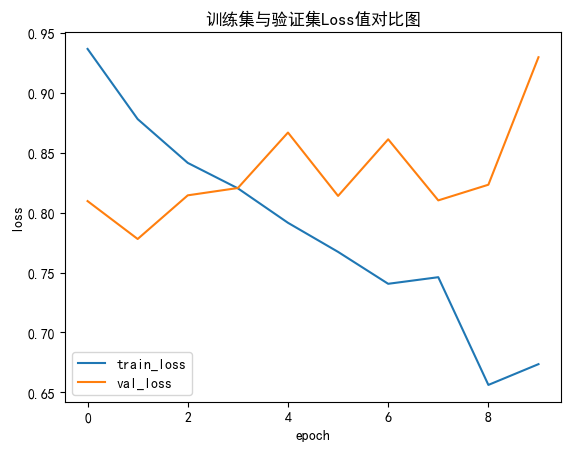

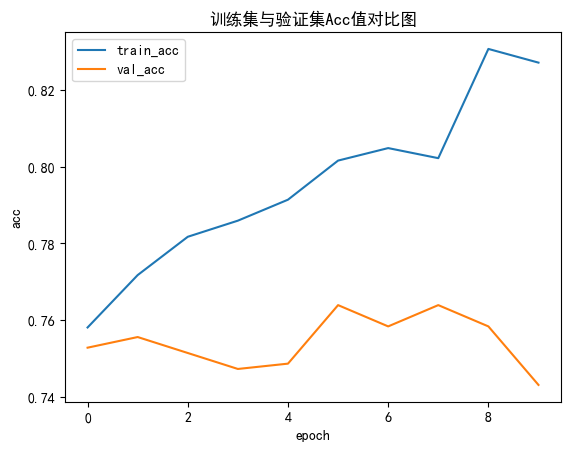

In [11]:
# 可视化
matplot_loss(loss_train, loss_val)
matplot_acc(acc_train, acc_val)

In [12]:
preds = []
model.load_state_dict(torch.load('../save_model/ImageNet Dogs/best_model_ResNet34.pth'))
for data, label in tqdm(test_loader):
    output = nn.functional.softmax(model(data.to(device)), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(os.path.join(test_dir, 'unknown')))
with open('../data/ImageNet Dogs/submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_dataset.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')

100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [00:45<00:00,  3.57it/s]
